In [37]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt


In [49]:
ticker = '7204.kl'
# Last 3 years closing prices starting from Jan 2, 2018.
 
now = dt.datetime.now()
startyear = 2018
startmonth = 1 
startday = 2
start = dt.datetime(startyear, startmonth, startday)
df = pdr.get_data_yahoo(ticker, start, now)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-10-29,5.73,5.60,5.60,5.64,2955600.0,5.64
2021-11-01,5.74,5.34,5.63,5.41,7053100.0,5.41
2021-11-02,5.62,5.42,5.42,5.50,4516200.0,5.50
2021-11-03,5.55,5.42,5.51,5.45,1422400.0,5.45
2021-11-05,5.55,5.42,5.49,5.47,2459300.0,5.47


In [50]:
## 14_Day RSI
df['Up Move'] = np.nan
df['Down Move'] = np.nan
df['Average Up'] = np.nan
df['Average Down'] = np.nan
# Relative Strength
df['RS'] = np.nan
# Relative Strength Index
df['RSI'] = np.nan

    

# Relative Strength Index (RSI):
## When the RSI surpasses the horizontal 30 reference level, it is a bullish sign and when it slides below the horizontal 70 reference level, it is a bearish sign.

In [51]:
## Calculate Up Move & Down Move
for x in range(1, len(df)):
    df['Up Move'][x] = 0
    df['Down Move'][x] = 0
    
    if df['Adj Close'][x] > df['Adj Close'][x-1]:
        df['Up Move'][x] = df['Adj Close'][x] - df['Adj Close'][x-1]
        
    if df['Adj Close'][x] < df['Adj Close'][x-1]:
        df['Down Move'][x] = abs(df['Adj Close'][x] - df['Adj Close'][x-1])  
        


In [52]:
## Calculate initial Average Up & Down, RS and RSI
df['Average Up'][14] = df['Up Move'][1:15].mean()
df['Average Down'][14] = df['Down Move'][1:15].mean()
df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
df['RSI'][14] = 100 - (100/(1+df['RS'][14]))


In [53]:
## Calculate rest of Average Up, Average Down, RS, RSI
for x in range(15, len(df)):
    df['Average Up'][x] = (df['Average Up'][x-1]*13+df['Up Move'][x])/14
    df['Average Down'][x] = (df['Average Down'][x-1]*13+df['Down Move'][x])/14
    df['RS'][x] = df['Average Up'][x] / df['Average Down'][x]
    df['RSI'][x] = 100 - (100/(1+df['RS'][x]))

## - You can ‘print(df)’ to see the DataFrame, it should look like a long table with 6 new columns.
# Plot the RSI and ‘Close Prices’ :

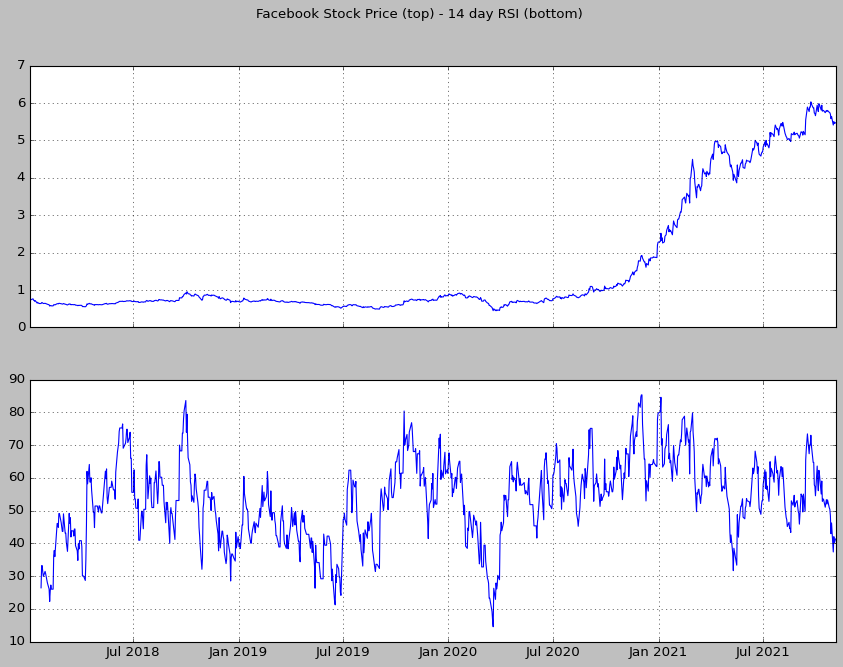

In [54]:
## Chart the stock price and RSI
#plt.style.use('_classic_test')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Facebook Stock Price (top) - 14 day RSI (bottom)')
axs[0].plot(df['Adj Close'])
axs[1].plot(df['RSI'])
axs[0].grid()
axs[1].grid()

# GENERATE BUY & SELL SIGNALS:

In [55]:
## Calculate the buy & sell signals
## Initialize the columns that we need
df['Long Tomorrow'] = np.nan
df['Buy Signal'] = np.nan
df['Sell Signal'] = np.nan
df['Buy RSI'] = np.nan
df['Sell RSI'] = np.nan
df['Strategy'] = np.nan
## Calculate the buy & sell signals
for x in range(15, len(df)):
    
    # Calculate "Long Tomorrow" column
    if ((df['RSI'][x] <= 40) & (df['RSI'][x-1]>40) ):
        df['Long Tomorrow'][x] = True
    elif ((df['Long Tomorrow'][x-1] == True) & (df['RSI'][x] <= 70)):
        df['Long Tomorrow'][x] = True
    else:
        df['Long Tomorrow'][x] = False
        
    # Calculate "Buy Signal" column
    if ((df['Long Tomorrow'][x] == True) & (df['Long Tomorrow'][x-1] == False)):
        df['Buy Signal'][x] = df['Adj Close'][x]
        df['Buy RSI'][x] = df['RSI'][x]
        
    # Calculate "Sell Signal" column
    if ((df['Long Tomorrow'][x] == False) & (df['Long Tomorrow'][x-1] == True)):
        df['Sell Signal'][x] = df['Adj Close'][x]
        df['Sell RSI'][x] = df['RSI'][x]
        
## Calculate strategy performance
df['Strategy'][15] = df['Adj Close'][15]
for x in range(16, len(df)):
    if df['Long Tomorrow'][x-1] == True:
        df['Strategy'][x] = df['Strategy'][x-1]* (df['Adj Close'][x] / df['Adj Close'][x-1])
    else:
        df['Strategy'][x] = df['Strategy'][x-1]

# Exit / Entry:

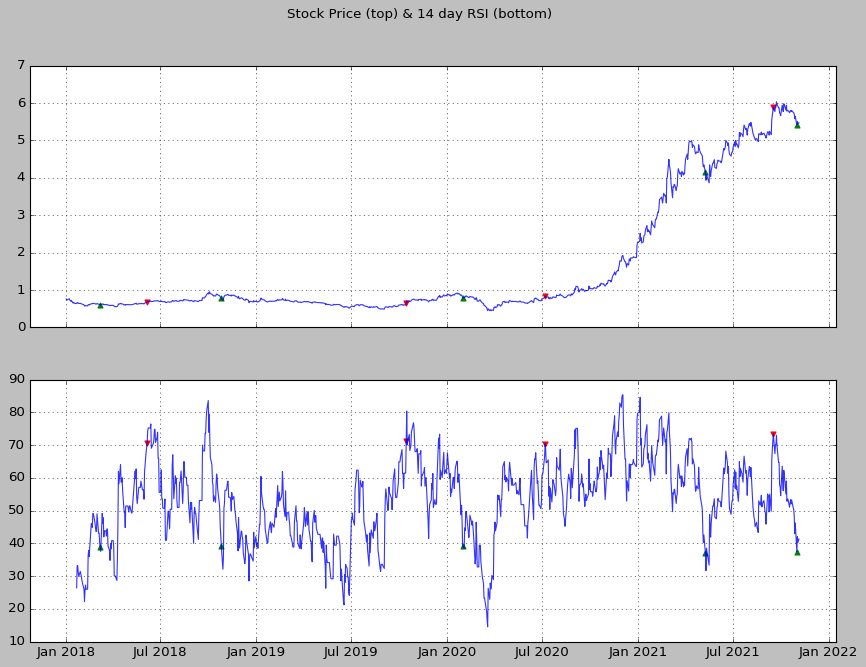

In [56]:
## Chart the buy/sell signals:
#plt.style.use('_classic_test')
fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
fig.suptitle('Stock Price (top) & 14 day RSI (bottom)')
## Chart the stock close price & buy/sell signals:
axs[0].scatter(df.index, df['Buy Signal'],  color = 'green',  marker = '^', alpha = 1)
axs[0].scatter(df.index, df['Sell Signal'],  color = 'red',  marker = 'v', alpha = 1)
axs[0].plot(df['Adj Close'], alpha = 0.8)
axs[0].grid()
## Chart RSI & buy/sell signals:
axs[1].scatter(df.index, df['Buy RSI'],  color = 'green', marker = '^', alpha = 1)
axs[1].scatter(df.index, df['Sell RSI'],  color = 'red', marker = 'v', alpha = 1)
axs[1].plot(df['RSI'], alpha = 0.8)
axs[1].grid()

# Moving Average Convergence Divergence (MACD):

In [57]:
## Calculate the MACD and Signal Line indicators
## Calculate the Short Term Exponential Moving Average
ShortEMA = df.Close.ewm(span=12, adjust=False).mean() 
## Calculate the Long Term Exponential Moving Average
LongEMA = df.Close.ewm(span=26, adjust=False).mean() 
## Calculate the Moving Average Convergence/Divergence (MACD)
MACD = ShortEMA - LongEMA
## Calcualte the signal line
signal = MACD.ewm(span=9, adjust=False).mean()

## Plot MACD & Signal Line:

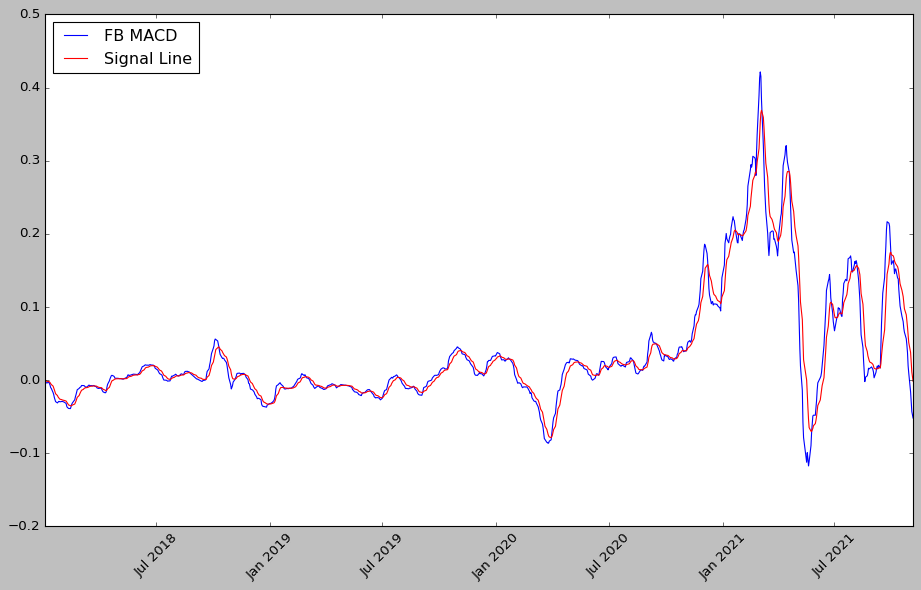

In [58]:
## Plot the Chart
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(df.index, MACD, label='FB MACD', color = 'blue')
plt.plot(df.index, signal, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

# Trading Facebook 3-Year Metrics:

In [59]:
## Performance statistics
## Number of trades
trade_count = df['Buy Signal'].count()
## Average Profit per/trade:
average_profit = ((df['Strategy'][-1] / df['Strategy'][15])**(1/trade_count))-1
## Number of days per/trade
total_days = df['Long Tomorrow'].count()
average_days = int(total_days / trade_count)
print('Strategy yielded ', trade_count, ' trades')
print('Average trade lasted ', average_days, ' days per trade')
print('Our average profit per trade was ', average_profit*100, '%')

Strategy yielded  5  trades
Average trade lasted  185  days per trade
Our average profit per trade was  6.823149557083119 %
